# Lab — Outliers

![Outlier meme](https://raw.githubusercontent.com/dcai-course/assets/master/outlier-meme.jpg)

You are given a clean dataset consisting of many pictures of dogs (the data distribution), and an evaluation dataset that contains outliers (dogs mixed with non-dogs). Your task is to implement and compare various methods for detecting outliers (strictly speaking, this is an anomaly detection task, because you're given a clean training set). You may implement some of the ideas presented in today's lecture, or you can look up other outlier detection algorithms in the linked references or online.

## Install dependencies

If you don't have them installed already, run the following cell.

In [1]:
# pip install Pillow matplotlib numpy scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


## Download and extract the dataset

We're working with a ~ 1.3 GB image dataset in this lab. Either download and extract it manually, or run the following cells.

In [2]:
!wget -nc https://github.com/dcai-course/dcai-lab/releases/download/v0.0.0/outliers.tar.gz
!tar xzf outliers.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.
'tar' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
# !curl -o https://github.com/dcai-course/dcai-lab/releases/download/v0.0.0/outliers.tar.gz
# I extracted manually

'curl' is not recognized as an internal or external command,
operable program or batch file.


## Visualize some of the data

In [1]:
import os
import numpy as np
from tqdm import tqdm

train_files = sorted([os.path.join('train', i) for i in os.listdir('train') if i.endswith('.JPEG')])
test_files = sorted([os.path.join('test', i) for i in os.listdir('test') if i.endswith('.JPEG')])
np.random.seed(1337) # for reproducibility
np.random.shuffle(train_files)
np.random.shuffle(test_files)
# ground truth, used for evaluation of your outlier detection implementation
with open('outliers_ground_truth.txt') as f:
    test_outliers = [os.path.join('test', i) for i in f.read().strip().split('\n')]
    test_outliers_mask = np.array([i in test_outliers for i in test_files])

In [2]:
import matplotlib.pyplot as plt
import PIL

def plot_images(paths, per_row=5):
    '''
    Visualize images by their paths.
    
    Shows whether an image is an outlier or not, using the ground-truth information.
    '''
    n = len(paths)
    cols = per_row
    rows = n // per_row
    plt.rcParams["figure.figsize"] = (15,4*rows)
    for i, path in enumerate(paths):
        ax = plt.subplot(rows, cols, i+1)
        img = PIL.Image.open(path)
        img = np.asarray(img)
        ax.imshow(img)
        if path in test_outliers:
            ax.set_title('outlier')
        ax.axis('off')
    plt.show()

First, let's visualize the training distribution:

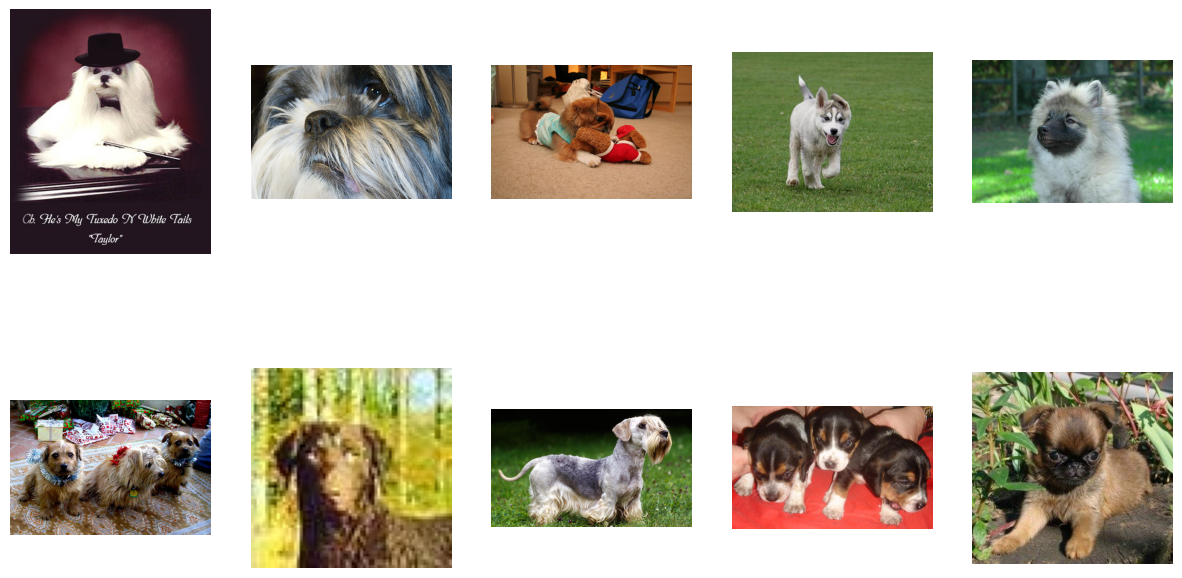

In [3]:
plot_images(train_files[:10])

Now, let's visualize the test distribution (which contains some outliers). The visualization code uses the ground-truth information to label outliers. Our goal in this lab is to find these outliers automatically.

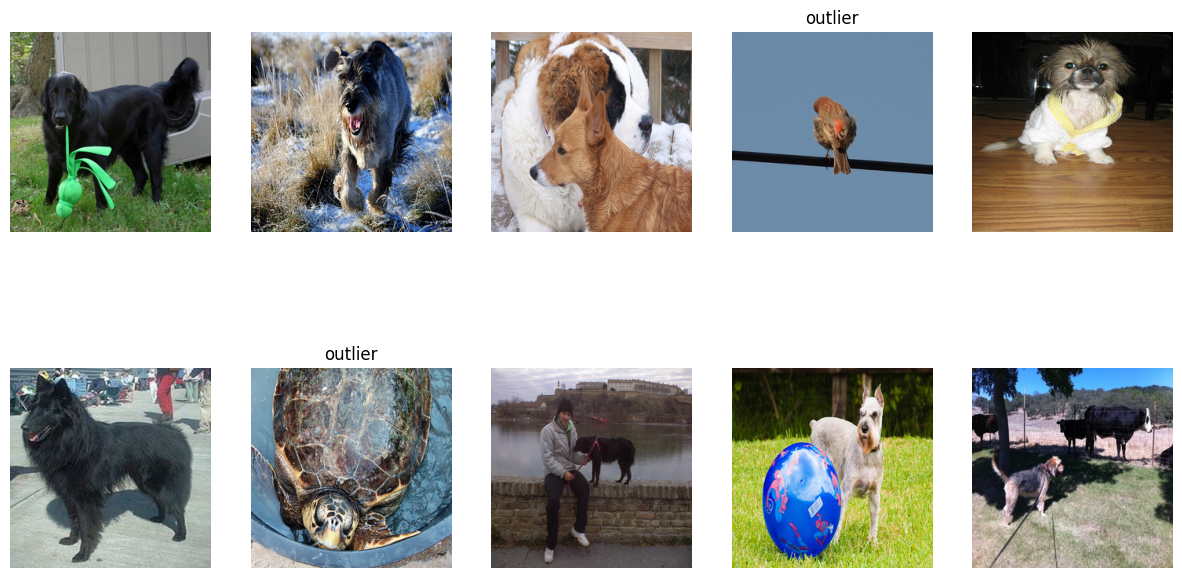

In [4]:
plot_images(test_files[:10])

## Evaluation metrics

Most methods we implement will assign as score to every datapoint, and we'll have to choose a threshold to decide which data points we consider outliers. To evaluate such methods, we can look at an ROC curve (true positive rate vs false positive rate), and if we want a single summary number, look at the AUROC (area under the ROC curve).

Here, we define some utilities to plot ROC curves for you.

In [5]:
from sklearn import metrics

def plot_roc(*scores_and_names):
    '''
    Plots an ROC curve and computes AUC, given a list of scores and method names.
    
    Call this function like plot_roc(scores1, 'name of method 1', scores2, 'name of method 2', ...)
    to compare different outlier detection methods.
    '''
    fpr = []
    tpr = []
    for score, name in zip(scores_and_names[::2], scores_and_names[1::2]):
        fpr, tpr, thresholds = metrics.roc_curve(test_outliers_mask, score)
        auc = metrics.roc_auc_score(test_outliers_mask, score)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.legend(loc=0)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

## Baseline methods

Here, we implement a couple really simple methods, just to show you how the pieces fit together. You can do a _lot_ better than these.

We want to compute a score for each datapoint that indicates how likely it is (compared to the others) to be an outlier (in this lab, these scores do not need to be calibrated as anything like probabilities, they just need to be meaningful relative to each other). The score for a datapoint is calculated based on the test image and features of the train distribution, but _not_ taking into account other datapoints in the test set or information on which other images in the test set are outliers or not.

### Random scores

The most basic baseline: assign each datapoint a random score.

Check yourself: what do you expect the ROC curve to look like, and what will be the AUC? Does this depend on what fraction of the dataset are outliers?

In [6]:
np.random.seed(1234)
random_ood_scores = np.random.uniform(size=len(test_files))

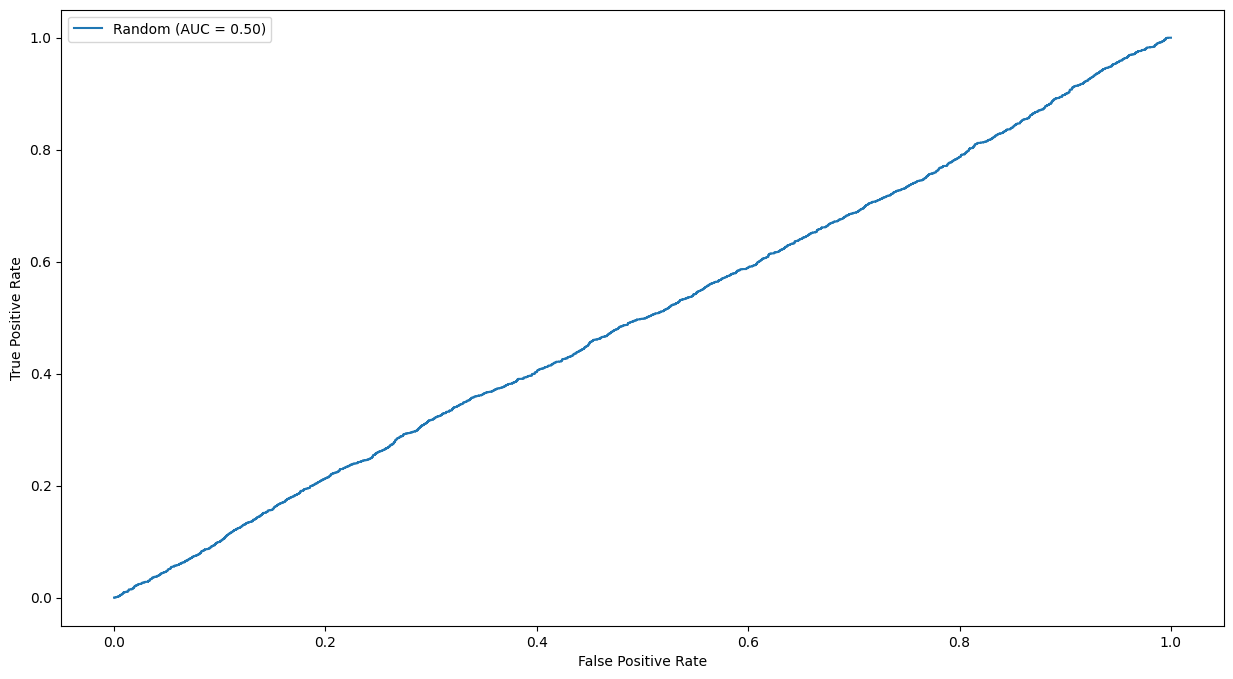

In [7]:
plot_roc(random_ood_scores, 'Random')

### Average color

As a really simple score, we can compute the average color of in-distribution images, and for a new image, compute its score as the difference between its average color and the average color of training images.

In [7]:
train_mean_pixel = np.zeros(3)
for path in tqdm(train_files):
    train_mean_pixel += np.asarray(PIL.Image.open(path).convert('RGB')).mean(axis=(0, 1))
train_mean_pixel /= len(train_files)

  0%|          | 0/10030 [00:00<?, ?it/s]

100%|██████████| 10030/10030 [00:57<00:00, 173.59it/s]


In [8]:
mean_pixel_ood_scores = []
for path in tqdm(test_files):
    img_mean_pixel = np.asarray(PIL.Image.open(path).convert('RGB')).mean(axis=(0, 1))
    diff = np.sum(np.abs(img_mean_pixel - train_mean_pixel))
    mean_pixel_ood_scores.append(diff)
mean_pixel_ood_scores = np.array(mean_pixel_ood_scores)

100%|██████████| 8546/8546 [00:20<00:00, 419.86it/s]


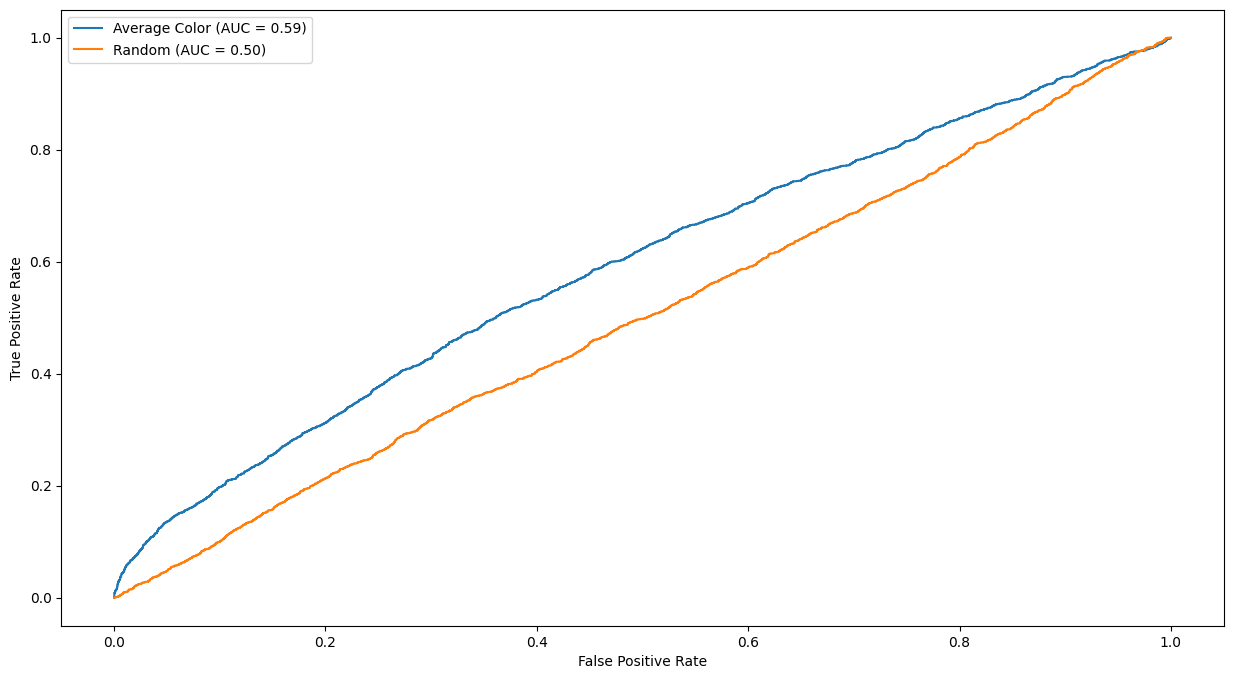

In [9]:
plot_roc(mean_pixel_ood_scores, 'Average Color', random_ood_scores, 'Random')

### KNN in image space, on resized images

It's not sensible to do KNN in image space, because the images are really large. But we can try resizing them to some fixed size, like 32x32, and doing KNN with L2 distance in that space.

In [11]:
# !pip install cleanlab

In [10]:
train_tiny_image_reps = []
for path in tqdm(train_files):
    train_tiny_image_reps.append(np.asarray(PIL.Image.open(path).convert('RGB').resize((32, 32))).flatten())
train_tiny_image_reps = np.stack(train_tiny_image_reps)

100%|██████████| 10030/10030 [00:22<00:00, 437.20it/s]


In [11]:
test_tiny_image_reps = []
for path in tqdm(test_files):
    test_tiny_image_reps.append(np.asarray(PIL.Image.open(path).convert('RGB').resize((32, 32))).flatten())
test_tiny_image_reps = np.stack(test_tiny_image_reps)

100%|██████████| 8546/8546 [00:08<00:00, 1035.78it/s]


In [12]:
from cleanlab.outlier import OutOfDistribution

tiny_ood = OutOfDistribution()
tiny_ood.fit(features=train_tiny_image_reps)
tiny_ood_scores = -tiny_ood.score(features=test_tiny_image_reps)

c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Fitting OOD estimator based on provided features ...


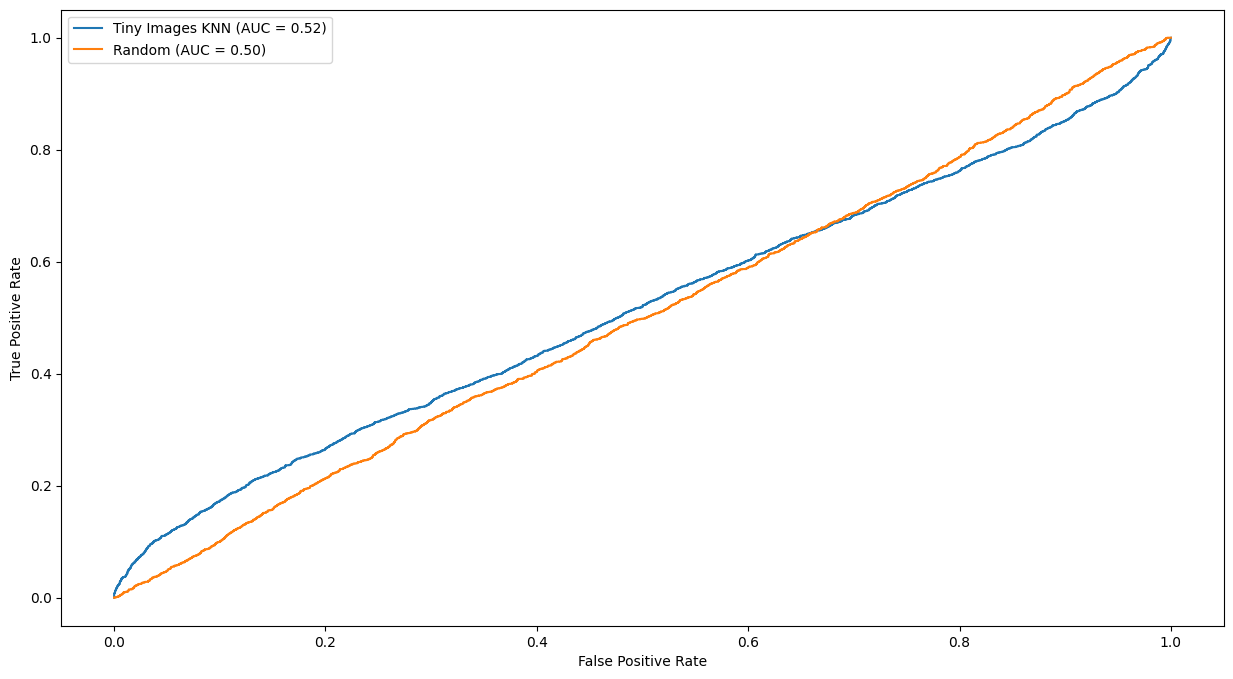

In [13]:
plot_roc(tiny_ood_scores, 'Tiny Images KNN', random_ood_scores, 'Random')

### Isolation forest on image histograms

It's not sensible to use the isolation forest algorithm directly on the high-dimensional image data, but we can try it on features computed from the image. Here, we compute image histograms as features.

In [14]:
def compute_histograms(paths):
    all_hists = []
    for path in tqdm(paths):
        x = np.asarray(PIL.Image.open(path).convert('RGB').resize((256, 256)))
        hists = []
        for c in range(3):
            hist, _ = np.histogram(x[:,:,c], bins=32, range=(0, 256))
            hists.append(hist)
        hist = np.concatenate(hists)
        all_hists.append(hist)
    return np.stack(all_hists)

In [15]:
train_histograms = compute_histograms(train_files)

100%|██████████| 10030/10030 [00:44<00:00, 223.25it/s]


In [16]:
test_histograms = compute_histograms(test_files)

100%|██████████| 8546/8546 [00:22<00:00, 378.00it/s]


In [17]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
isolation_forest.fit(train_histograms)

isolation_scores = -isolation_forest.score_samples(test_histograms) # negate, so higher score = more abnormal

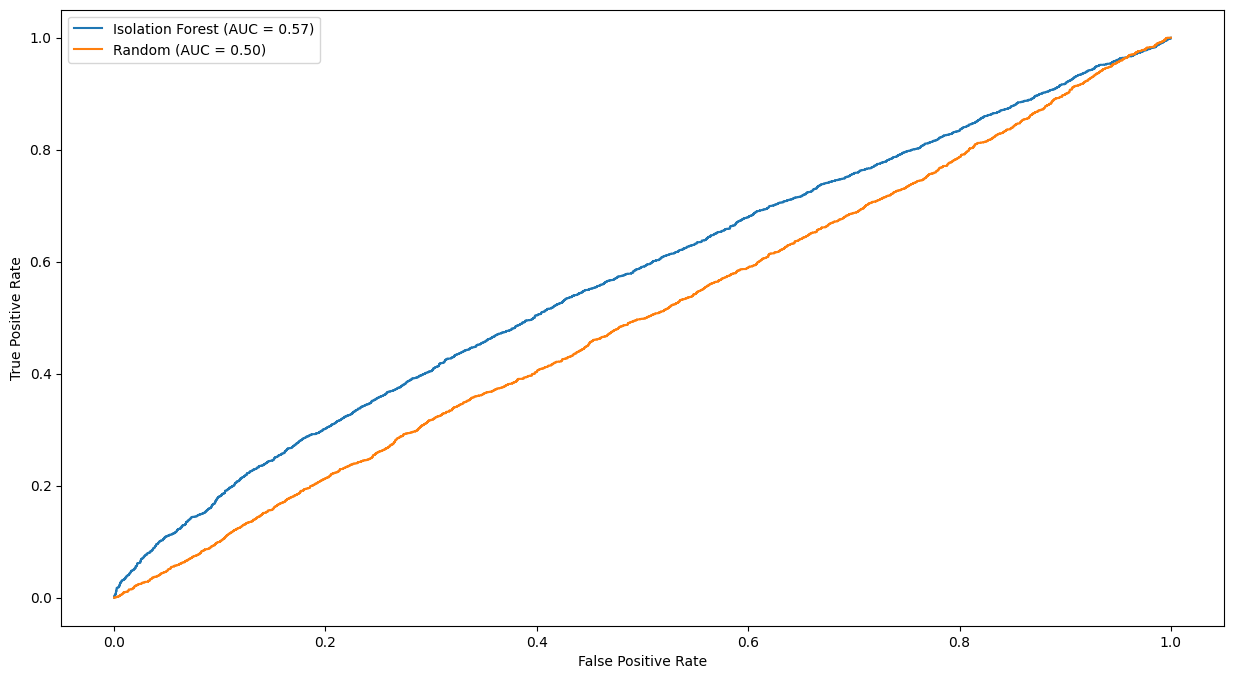

In [18]:
plot_roc(isolation_scores, 'Isolation Forest', random_ood_scores, 'Random')

### Comparing the (very simple) methods we implemented

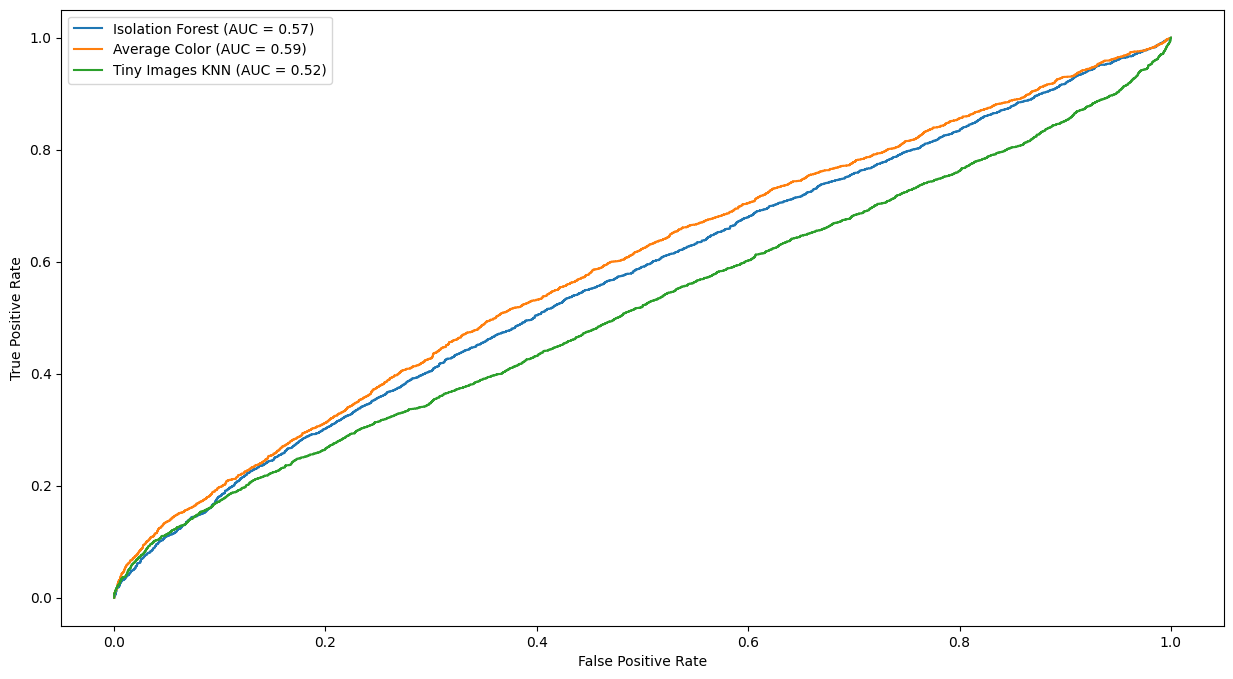

In [19]:
plot_roc(isolation_scores, 'Isolation Forest', mean_pixel_ood_scores, 'Average Color', tiny_ood_scores, 'Tiny Images KNN')

## Exercise: implement and compare outlier detection methods

Implement and compare various methods for outlier detection to find outliers in the test set (`test_files`). Ground-truth information, used for evaluating your outlier detection algorithm, is in `test_outliers` / `test_outliers_mask`.

You should compute a score for each datapoint.  The scores should be computed based as a function of each test image (that may depend on statistics of the training data), but not any information about the other test images or which test examples are outliers or not. That means, for example, that you can't train a binary classifier on whether an image is in-distribution or out-of-distribution by using the outlier images and "labels" in `test_outliers` (that is only for evaluation). The scenario is that you've been able to train on the train distribution, and then an anomaly detection system is deployed "live", where it handles one datapoint that it sees at a time (and never gets ground-truth information on whether that datapoint was an outlier).

We want scores to take higher values for test images which are actually outliers vs those which are not.

As one of the methods you implement, we suggest using embeddings from a pre-trained model and using KNN distance as a score. A good place to find pre-trained models is [HuggingFace](https://huggingface.co/models). Another good place to look is the timm library; here is a [tutorial on feature extraction](https://huggingface.co/docs/timm/feature_extraction). You can find a list of timm models [here](https://huggingface.co/docs/timm/models).

Another idea is to train an autoencoder and use reconstruction loss as a score. You might find [this tutorial](https://towardsdatascience.com/simplifing-image-outlier-detection-with-alibi-detect-6aea686bf7ba) helpful.

You should be able to get to AUROC > 0.95.

The dataset used in this lab is taken from ImageNet (train data comes from the ImageNet train set, and test data comes from the ImageNet validation set). Many pre-trained models available online are trained on ImageNet. How does this help explain the great performance of the pre-trained model + KNN distance method?

After implementing a couple different methods, compare them using `plot_roc`.

Also, you might find it interesting to qualitiatively evaluate your outlier detection implementations. Plot the highest-scoring images and the lowest-scoring images using `plot_images`.

In [ ]:
# YOUR CODE HERE

In [21]:
import torch
torch.cuda.is_available()

True

Use this quick [guide](https://franky07724-57962.medium.com/using-keras-pre-trained-models-for-feature-extraction-in-image-clustering-a142c6cdf5b1), 

Problems: 
1. output size
   1. but because `VGG` output different size feature and I don't know how to make the feature same size..
   2. Edit, `pooling = 'max'` seems to solve it
2. `preprocessing_input` has a problem of `IndexError: index 1 is out of bounds for ...`
   1. I am just excluding those files, by `my_list = train_files',  'excluded_index = [15, 135, 136]', 'filtered_trained = [element for index, element in enumerate(my_list) if index not in excluded_index]`
   2. Edit, it doesn't work
   3. `.convert('RGB)` solves this
3. There's some memory issue.
   1. Let's just use solution's help 
   



In [32]:

# from keras.preprocessing import image # utils are better
import keras.utils as image
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

model=VGG16(weights='imagenet', include_top=False, pooling='max')
# model.summary()

def chunks(l, n):
    return [l[i:i+n] for i in range(0, len(l), n)]


# new compute_features
def compute_features2(paths, model, batch_size):
    features = None
    for chunk in tqdm(chunks(paths, batch_size)):
        images = [PIL.Image.open(i).convert('RGB') for i in chunk]

        chunk_features = None
        for img in images:
            img_data = image.img_to_array(img)
            img_data = np.expand_dims(img_data, axis=0)
            img_data = preprocess_input(img_data)
            feature = model.predict(img_data)
            feature = np.array(feature).flatten()
            if chunk_features is None:
                chunk_features = feature
            else:
                chunk_features = np.vstack([chunk_features, feature])
        if features is None:
            features = chunk_features
        else:
            features = np.vstack([features, chunk_features])
    return images


def compute_features(paths, model):
    features = None 
    for path in tqdm(paths):
        img = PIL.Image.open(path).convert('RGB')
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        feature = model.predict(img_data)
        feature_np = np.array(feature).flatten()

        if features is None:
            features = feature_np
        else:
            features = np.vstack([features, feature_np])
    return features


In [34]:


# we use the model to compute the features
# train_features = compute_features(train_files, model)
# train_features = compute_features2(train_files, model, 30)
train_features = compute_features2(train_files, model, 50)
# image.img_to_array(o)


  0%|          | 0/201 [00:00<?, ?it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 1/201 [00:03<11:35,  3.48s/it]

1/1 [==============================] - 0s 19ms/step


  1%|          | 2/201 [00:06<11:09,  3.37s/it]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 3/201 [00:10<11:30,  3.49s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 4/201 [00:13<11:23,  3.47s/it]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 5/201 [00:17<11:05,  3.40s/it]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 6/201 [00:20<10:52,  3.35s/it]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 7/201 [00:23<11:03,  3.42s/it]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 8/201 [00:27<10:54,  3.39s/it]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 9/201 [00:30<10:55,  3.42s/it]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 9/201 [00:41<14:36,  4.57s/it]


ResourceExhaustedError: Graph execution error:

Detected at node 'vgg16/block1_conv2/Relu' defined at (most recent call last):
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Long\AppData\Local\Temp\ipykernel_8216\2582914094.py", line 4, in <module>
      train_features = compute_features2(train_files[1:100], model, 30)
    File "C:\Users\Long\AppData\Local\Temp\ipykernel_8216\4019968959.py", line 24, in compute_features2
      feature = model.predict(img_data)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 2253, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 2041, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 2027, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 2015, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
      return self(x, training=False)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\Long\Anaconda3\envs\DL_env\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'vgg16/block1_conv2/Relu'
OOM when allocating tensor with shape[1,64,2304,1728] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node vgg16/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_31916]

Give up on the VGG method, let's use what's mentioned in the solution

In [42]:
# import timm

from transformers import AutoFeatureExtractor, ResNetForImageClassification

feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
# use GPU if available
if torch.cuda.is_available():
    model = model.to('cuda:0')
    
def compute_embeddings(paths, batch_size=50):
    embeddings = None
    for chunk in tqdm(chunks(paths, batch_size)):
        images = [PIL.Image.open(i).convert('RGB') for i in chunk]
        inputs = feature_extractor(images, return_tensors="pt")
    if torch.cuda.is_available():
        inputs = inputs.to('cuda:0')
    with torch.no_grad():
        outputs = model(**inputs)
    embedding = outputs.logits.cpu().numpy()
    if embeddings is None:
        embeddings = embedding
    else:
        embeddings = np.vstack([embeddings, embedding])
    return embeddings


In [43]:

train_embeddings = compute_embeddings(train_files)

100%|██████████| 201/201 [02:05<00:00,  1.60it/s]


In [48]:
test_embeddings = compute_embeddings(test_files)

100%|██████████| 171/171 [01:23<00:00,  2.05it/s]


In [53]:
from cleanlab.outlier import OutOfDistribution
ood = OutOfDistribution()
ood.fit(features=train_embeddings)

Fitting OOD estimator based on provided features ...


In [54]:


ood_test_scores = -ood.score(features=test_embeddings)

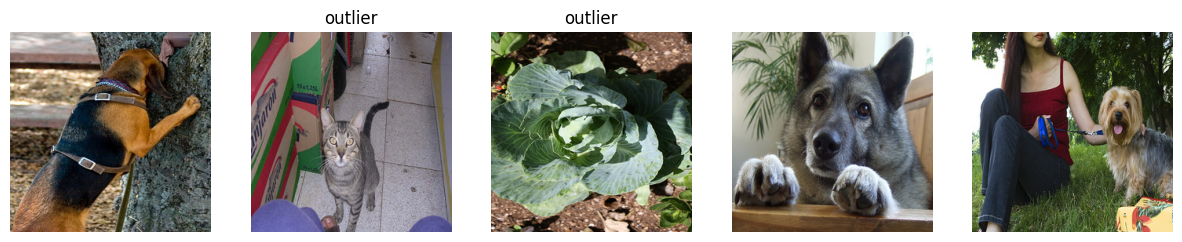

In [55]:
idx_by_score = np.argsort(ood_test_scores)
plot_images(np.array(test_files)[idx_by_score[-5:]])

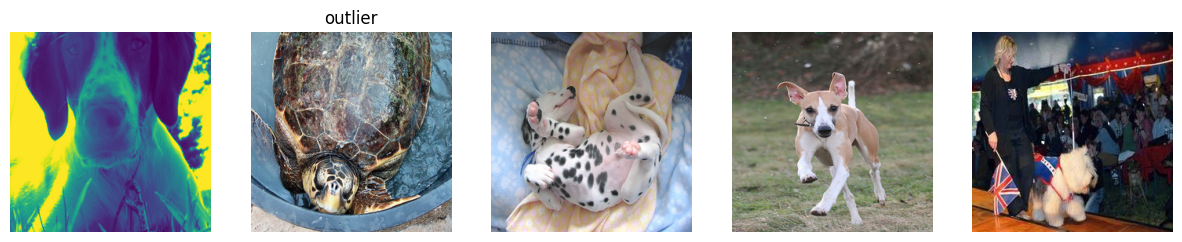

In [56]:
plot_images(np.array(test_files)[idx_by_score[:5]])

In [47]:
plot_roc(ood_test_scores, 'embedded features')

ValueError: Found input variables with inconsistent numbers of samples: [8546, 46]

In [ ]:
plot_roc(isolation_scores, 'Isolation Forest', mean_pixel_ood_scores, 'Average Color', tiny_ood_scores, 'Tiny Images KNN', EF_ood_scores, 'my method')

something went clearly wrong, but i am too lazy to complete this one...